In [122]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [123]:
## Read coordinates and indices

grid_coordinates = []
with open('../../../Grids/Periodic_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../../Grids/Periodic_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../../Grids/Periodic_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

bott_indices = []
with open('../Periodic_Bott_indices_B_scale_0250.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled

## IMPORTANT WE WILL USE THE GRID SCALED FOR ROTATIONS THIS MAKES THE WORK EASIER ##

# Read the phases in
evec_phases = []
with open('../../../Separate_files/Periodic_args.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        ele = line.strip('\n')
        val = float(ele)
        evec_phases.append(val)
        line = reader.readline()

phases_ind = [(ele, count) for count, ele in enumerate(evec_phases)]

# Time evolution by giving index of states
def time_evolve_evec(group_of_states, coefficients, time, evec, eval):

    hbar = 1
    t = time

    # Make the group of states in to vectors and multiply with time op
    phis = [c*np.exp(-1j*(eval[i]/hbar)*t)*evec[i] for i, c in zip(group_of_states, coefficients)]

    # Make a linear combination equally divided
    a = len(phis)
    psi = sum([x for x in phis])

    phi_norm = psi / (np.sqrt(np.vdot(psi,psi)))

    density_of_states = [(x.conj() * x).real for x in phi_norm]
    
    return phi_norm, density_of_states


In [124]:
# Hamiltonian cell
# The pure Hamiltonian
def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs


# The unpure we just keep both positive and negative perturbations
# It is only a matter of scale
def Hamil_solve_perturb(z, w, B, perturb_vals):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H0 = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = np.arange(0, dim_H)
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Scaling via J, maybe energy factor
    J = 1

    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    terms_by_sites = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        terms = [-J * np.exp(1j * t) for t in phases]
        terms_by_sites.append(terms)

    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, terms_by_sites):
        for k, t in zip(y, z):
            H0[x][k] = t

    # Add the diagonal perturbation

    perturbs = [abs(x) for x in perturb_vals]
    
    H_prime = np.diag(perturbs)
    #H_prime = np.diag(perturb_vals)

    # This is the new hamiltonian we will solve, just as previously
    H = H0 + H_prime

    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    
    return eig_vals, eig_vecs


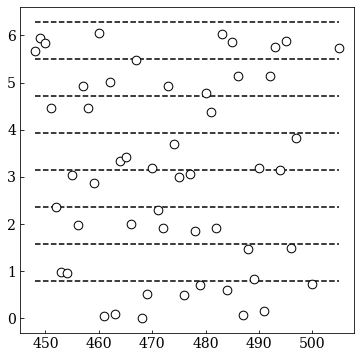

In [125]:
# We plot the phases of the unperturbed eigenvectors for help in selecting linear combinations
fig, ax = plt.subplots(figsize= (6,6))

elements_of_interval = np.loadtxt('filter_evecs_flux_025.txt')
states_nz_bi = [int(x[1]) for x in elements_of_interval]
xs = states_nz_bi
ys = [ele for ele, i in phases_ind if i in states_nz_bi]
# Actual plot
ax.scatter(x= xs, y= ys, edgecolors= 'k', facecolor= 'w', s= 75, zorder= 2)

# Plot of guide lines
# Define neccessary scalars
N = 8
ks = np.arange(1,9)
ns = np.arange(0,8)
# Calculate ps
ps = [(2*np.pi)/(N)*k for k in ks]

min_x = min(xs)
max_x = max(xs)

for i in ps:
    ax.hlines(y= i, xmin= min_x, xmax= max_x, linestyles= '--', color= 'k', zorder= 1)

plt.show()

In [126]:
# In this cell we calculate the unperturbed Hamiltonian, so that we may gauge the energy difference
# The energy difference is used for generating the perturbations
# Set the value of the magnetic field
B_full = (2*np.pi)/(0.041666666666666664**2)
B_scale = 0.25

evals, evecs = Hamil_solve(grid_scaled, jump_scaled, (B_scale)*B_full)

# We already know we want to look at the "double step" of the flux cutout
# Calculate every delta_E between every consecutive state
delta_Es = [evals[i+1] - evals[i] for i in states_nz_bi if i != states_nz_bi[-1]]
# Calculate an average delta_E so that we have an estimate of perturbation size 
avg_delta_Es = (1/(len(delta_Es))) * sum(delta_Es)
# Note that the calculation only needs to happen once before being put into generator script
print(avg_delta_Es)

0.03297425461935525


In [127]:
# Load in Vs from other script and call them perturbs
perturbs = np.loadtxt('Perturb_gen/Perturbs_flux_025.txt')
# Define the scaling of Vs
V_scales = np.arange(0,10.1, 0.1)

all_vals = [Hamil_solve_perturb(grid_scaled, jump_scaled, (B_scale)*B_full, x*perturbs) for x in V_scales]

all_evals = [x for x,y in all_vals]
all_evecs = [y for x,y in all_vals]

pure_evals = all_evals[0]
pure_evecs = all_evecs[0]

unpure_evals = all_evals[1:]
unpure_evecs = all_evecs[1:]


In [128]:
# We now write up three list in which we classify the different relation to gap or bulk of the states in "double step"
gap_group = [462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475]
# These are only some

gap_group1 = [462, 463]
gap_group2 = [462, 464]
gap_group3 = [462, 465]
gap_group4 = [462, 466]

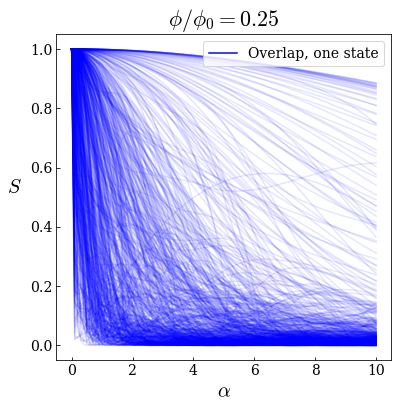

In [129]:
# Calculate overlaps of eigenvectors

inner_products = []
for ele in all_evecs:
    inner_product_V = [np.vdot(pure, unpure) for pure, unpure in zip(pure_evecs, ele)]
    inner_products.append(inner_product_V)

overlaps = [[(x.conj() * x).real for x in ele] for ele in inner_products]

fig, ax = plt.subplots(figsize= (6,6))
dim = len(grid_scaled)

all_groups = [gap_group]
colors = ['r']

# Here we check the overlaps as a function of increased perturbation for all in a particular gap with density overlaps for V= 0
for j, ele in enumerate(evecs):
    ys = [overlaps[i][j] for i in range(len(V_scales))]
    ax.plot(V_scales, ys, linestyle= '-', linewidth= 1.5, color= 'b', alpha= 0.1)

ax.plot([],[], color= 'b', linestyle= '-', label= 'Overlap, one state')

ax.set_title(r'$\phi/\phi_0 = {}$'.format(B_scale))
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$S$', rotation= 0)
ax.yaxis.set_label_coords(-0.125, 0.5)

ax.legend(loc= 1)
plt.savefig("example_overlap_flux_025.png", bbox_inches= 'tight')
plt.show()

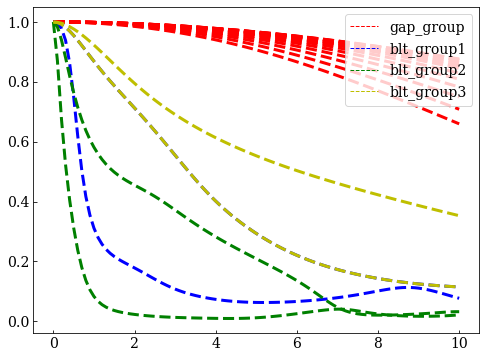

In [130]:
# Calculate overlaps of eigenvectors

inner_products = []
for ele in all_evecs:
    inner_product_V = [np.vdot(pure, unpure) for pure, unpure in zip(pure_evecs, ele)]
    inner_products.append(inner_product_V)

overlaps = [[(x.conj() * x).real for x in ele] for ele in inner_products]

fig, ax = plt.subplots(figsize= (8,6))
dim = len(grid_scaled)

all_groups = ['gap_group', 'blt_group1', 'blt_group2', 'blt_group3']
states_over = [gap_group, [459, 460], [452, 454], [460, 461]]
colors = ['r', 'b', 'g', 'y']

# Here we check the overlaps as a function of increased perturbation for all in a particular gap with density overlaps for V= 0

for type, col, states in zip(all_groups, colors, states_over):
    states_sub = states
    ax.plot([], [], linestyle= '--', linewidth= 1, label= f'{type}', color= col)
    for j in states_sub:
        ys = [overlaps[i][j] for i in range(len(V_scales))]
        ax.plot(V_scales, ys, linestyle= '--', linewidth= 3, color= col)

ax.legend(loc=1)
plt.show()


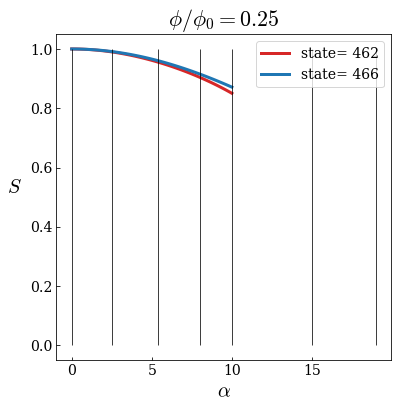

In [131]:
# Plot only a specified group
fig, ax = plt.subplots(figsize= (6,6))
blt_group1 = [459, 460]
blt_group2 = [452, 454]
blt_group3 = [460, 461]
blt_group4 = [497, 500]
target_group = gap_group4

# We now check for which sums of overlaps are greater than or equal to 0.66
overlaps_of_group = []
for j in target_group:
    overlaps_ele = [overlaps[i][j] for i in range(len(V_scales))]
    overlaps_of_group.append(overlaps_ele)


# Plot overlaps
for j, col in zip(target_group, ['tab:red','tab:blue']):
    ys = [overlaps[i][j] for i in range(len(V_scales))]
        
    ax.plot(V_scales, ys, linestyle= '-', linewidth= 3, label= f'state= {j}', color= col, zorder= 1)


select_Vs = [0, 2.5, 5.4, 8, 10, 15, 19]

for v in select_Vs:
    ax.vlines(x= v, ymin= 0, ymax= 1, linestyles= '-', color= 'k', linewidth= 0.75, zorder= 2)

ax.legend(loc= 1)
ax.set_title(r'$\phi/\phi_0 = {}$'.format(B_scale))
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$S$', rotation= 0)
ax.yaxis.set_label_coords(-0.125, 0.5)
#plt.savefig("example_decrease_of_overlaps_025.png", bbox_inches= 'tight')
plt.show()

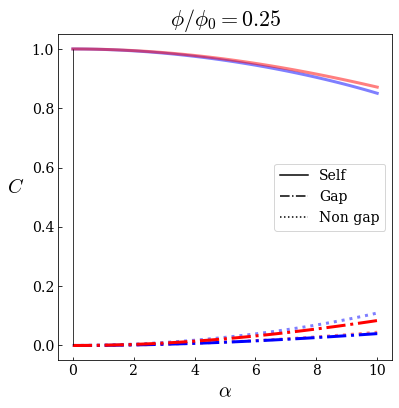

In [132]:
group = target_group
# We attempt to change so that the perturbed states 667 and 670 are compare to all non-perturbed eigenvectors
inner_products_specific = [[[np.vdot(vecs[ele], x) for x in pure_evecs] for vecs in all_evecs] for ele in group]
overlaps_specific = [[[(x.conj() * x).real for x in xs] for xs in ele] for ele in inner_products_specific]

# Sticking to just the state 667 we plot how it decreases as a function of increasing scaling
fig, ax = plt.subplots(figsize= (6,6))

for eles, col in zip(enumerate(group), ['b', 'r']):
    kount, state = eles
    # Start by plotting the overlap of the perturbed state with its own non-perturbed state
    ys_self_overlap = [overlaps_specific[kount][count][state] for count, ele in enumerate(V_scales)]
    ax.plot(V_scales, ys_self_overlap, linestyle= '-', linewidth= 3, color= col, alpha= 0.5, zorder= 1)
    # Now find the overlap with the rest of the unperturbed eigenstate. Segement these into eigenstates in or not in gap
    # We then sum the gap neighbours and plot per alpha, and similar for non gap states
    in_gap_overlaps = []
    outside_gap_overlaps = []

    for t in range(len(V_scales)):
        ys_gap_at_t = np.sum([overlaps_specific[kount][t][count] for count, ele in enumerate(evecs) if count != state and count in gap_group])
        in_gap_overlaps.append(ys_gap_at_t)
        
        ys_no_gap_at_t = np.sum([overlaps_specific[kount][t][count] for count, ele in enumerate(evecs) if count != state and count not in gap_group])
        outside_gap_overlaps.append(ys_no_gap_at_t)
    
    ax.plot(V_scales, in_gap_overlaps, linestyle= '-.', linewidth= 3, color= col, alpha= 1, zorder= 3)
    ax.plot(V_scales, outside_gap_overlaps, linestyle= ':', linewidth= 3, color= col, alpha= 0.5, zorder= 2)

ax.set_title(r'$\phi/\phi_0 = {}$'.format(B_scale))
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$C$', rotation= 0)
ax.yaxis.set_label_coords(-0.125, 0.5)

ax.plot([],[], color= 'k', linestyle= '-', label= 'Self')
ax.plot([],[], color= 'k', linestyle= '-.', label= 'Gap')
ax.plot([],[], color= 'k', linestyle= ':', label= 'Non gap')

select_Vs = [0]
for v in select_Vs:
    ax.vlines(x= v, ymin= 0, ymax= 1, linestyles= '-', color= 'k', linewidth= 0.75, zorder= 4)
    
ax.legend(loc= 0)

empty = '_'
name_file = empty.join([str(x) for x in group])

#plt.savefig(f"es_time_evolve/{name_file}/example_overlap_change_flux_025.png", bbox_inches= 'tight')

plt.show()

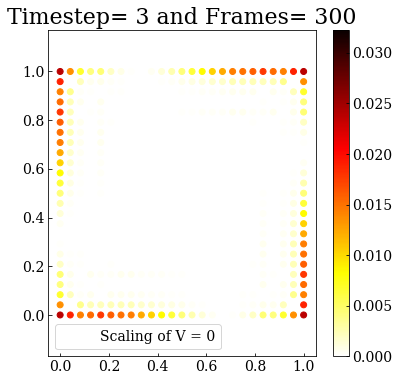

In [133]:
## Magic line for animation
%matplotlib inline
# Attempt at animating time evolution

all_vals_select = [Hamil_solve_perturb(grid_scaled, jump_scaled, (B_scale)*B_full, x*perturbs) for x in select_Vs]

all_evals_select = [x for x,y in all_vals_select]
all_evecs_select = [y for x,y in all_vals_select]

for vs, evecs, evals in zip(select_Vs, all_evecs_select, all_evals_select):
    # Set figure up first
    fig, ax = plt.subplots(figsize=(6,6))
    # Set bascis
    sites = ax.scatter(x=[], y=[], c=[])

    xs = [w[0] for w in grid_scaled]
    ys = [w[1] for w in grid_scaled]


    # Set timesteps, state of choice for animation, and number of frames
    timestep = 3
    n_frames = 300
    coefs = [1,1]

    psi_0, dos_0 = time_evolve_evec(group, coefs, 0, pure_evecs, pure_evals)

    dos_max = max(dos_0)

    plt.set_cmap('hot_r')

    # This function will do the animating
    def update(i):
        plt.clf()
        # t is the steps we progress, timestep sets the steplength
        t = i * timestep

        # Using the time evolution to find density of states for each increment
        psi, dos = time_evolve_evec(group, coefs, t, evecs, evals)
        cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
        plt.plot([],[], linestyle= '', label= f'Scaling of V = {vs}')
        plt.title(f'Timestep= {timestep} and Frames= {n_frames}')
        plt.legend(loc= 3)
        plt.colorbar(cf)
        plt.axis('equal')


    anim = FuncAnimation(fig, update, frames= n_frames, interval=250)

    name_perturb_temp = str(vs)
    name_perturb = name_perturb_temp.replace(".", "_")
    empty = '_'
    name_file = empty.join([str(x) for x in target_group])

    anim.save(f'es_time_evolve/{name_file}/Scale_{name_perturb}.gif', writer='imagemagick', fps=24)

    #anim


In [134]:
"""times = [np.arange(0,240,80)]
for v, time in zip(select_Vs, times):
    for t in time:
        # Set figure up first
        fig, ax = plt.subplots(figsize=(6,6))

        # Plot all possible paths between vertices
        for i,j in zip(grid_scaled, jump_scaled):
            xs = [w[0] for w in j]
            ys = [w[1] for w in j]
            for l,k in zip(xs,ys):
                ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)

        # Get points for scatter plot
        xs = [w[0] for w in grid_scaled]
        ys = [w[1] for w in grid_scaled]

        # Time evolution segment
        coefs = [1,1]
        # Initial setup
        psi_0, dos_0 = time_evolve_evec(group, coefs, 0, pure_evecs, pure_evals)
        dos_max = max(dos_0)

        # Actual evolution
        time = t
        psi, dos = time_evolve_evec(group, coefs, time, all_evecs[v * 10], all_evals[v * 10])

        # Plotting part
        cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
        plt.colorbar(cf)
        plt.axis('equal')

        name_temp = str(t)
        name = name_temp.replace(".", "_")

        v_name_temp = str(v)
        v_name = v_name_temp.replace(".", "_")
        plt.set_cmap('hot_r')
        plt.savefig(f'blt_time_evolve/{name_file}/TE_frames/V_{v_name}/t_{name}.png', bbox_inches= 'tight')
        plt.close()
"""

'times = [np.arange(0,240,80)]\nfor v, time in zip(select_Vs, times):\n    for t in time:\n        # Set figure up first\n        fig, ax = plt.subplots(figsize=(6,6))\n\n        # Plot all possible paths between vertices\n        for i,j in zip(grid_scaled, jump_scaled):\n            xs = [w[0] for w in j]\n            ys = [w[1] for w in j]\n            for l,k in zip(xs,ys):\n                ax.plot([i[0], l], [i[1], k], color= \'k\', zorder= 1, linewidth= 0.5)\n\n        # Get points for scatter plot\n        xs = [w[0] for w in grid_scaled]\n        ys = [w[1] for w in grid_scaled]\n\n        # Time evolution segment\n        coefs = [1,1]\n        # Initial setup\n        psi_0, dos_0 = time_evolve_evec(group, coefs, 0, pure_evecs, pure_evals)\n        dos_max = max(dos_0)\n\n        # Actual evolution\n        time = t\n        psi, dos = time_evolve_evec(group, coefs, time, all_evecs[v * 10], all_evals[v * 10])\n\n        # Plotting part\n        cf = plt.scatter(x= xs, y= ys, 